# Fine-Tuning de BERT para Análisis de Sentimiento (SST-2)

**Objetivo:** En este notebook, adaptaremos un modelo de lenguaje pre-entrenado (BERT) para una tarea específica: **Clasificación de Sentimientos**. Utilizaremos el dataset SST-2 (Stanford Sentiment Treebank) que contiene frases etiquetadas como positivas o negativas.

Este proceso se conoce como **Transfer Learning**. Tomamos un modelo que ya "sabe" leer inglés y le enseñamos a distinguir polaridad emocional.

---
### 1. Instalación de Dependencias

Para comenzar, necesitamos instalar las librerías del ecosistema **Hugging Face**.

- `transformers`: Contiene los modelos y arquitecturas (como BERT).
    
- `datasets`: Para descargar y gestionar datos de texto de forma eficiente.
    
- `evaluate`: Para calcular métricas de rendimiento (como la exactitud).
    
- `accelerate`: Optimiza el entrenamiento en GPU/TPU.
    

In [46]:
%pip install transformers datasets evaluate accelerate

---

### 2. Importación de Librerías y Configuración

Importamos los módulos necesarios y definimos las **constantes globales**. Es una buena práctica de ingeniería centralizar los hiperparámetros al inicio del notebook para facilitar cambios futuros sin tener que buscar en todo el código.


In [47]:
# pyright: reportMissingImports=false
import os
import numpy as np
import torch
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# --- Configuración Global ---
MODEL_NAME = "bert-base-uncased"   # Modelo base (puedes probar "distilbert-base-uncased" para mayor velocidad)
TASK = "sst2"                      # Sub-tarea del benchmark GLUE
NUM_LABELS = 2                     # Positivo (1) o Negativo (0)
MAX_LENGTH = 128                   # Longitud máxima de la secuencia de tokens

# Configuración para demostración rápida
USE_SMALL_SUBSET = True  # Cambiar a True si solo quieres probar que el código funciona rápido
SUBSET_SIZE = 1000        # Número de muestras si se usa el subset

---

### 3. Carga del Dataset (GLUE SST-2)

Utilizaremos el dataset **SST-2**, parte del benchmark GLUE.

- **Train:** Datos para enseñar al modelo.
    
- **Validation:** Datos para evaluar qué tan bien está aprendiendo durante el entrenamiento.
    

> **Nota:** Si activamos `USE_SMALL_SUBSET`, reducimos drásticamente los datos. Esto es útil para depurar el código (debugging) sin esperar horas de entrenamiento.


In [48]:
# Cargar el dataset desde el Hub de Hugging Face
dataset = load_dataset("glue", TASK)

# Visualización rápida de la estructura
print("Estructura del dataset:", dataset)
print("Ejemplo de dato:", dataset['train'][0])

# Opcional: Crear subconjunto para demostración rápida
if USE_SMALL_SUBSET:
    print(f"Usando subconjunto de {SUBSET_SIZE} ejemplos.")
    dataset["train"] = dataset["train"].shuffle(seed=42).select(range(SUBSET_SIZE))
    dataset["validation"] = dataset["validation"].shuffle(seed=42).select(range(200))

Estructura del dataset: DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})
Ejemplo de dato: {'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}
Usando subconjunto de 1000 ejemplos.


---

### 4. Tokenización y Preprocesamiento

Los modelos de Deep Learning no entienden texto (strings), solo entienden números.

El Tokenizer se encarga de:

1. Partir las frases en piezas más pequeñas (tokens).
    
2. Convertir esos tokens en IDs numéricos que corresponden al vocabulario del modelo.
    
3. Añadir tokens especiales (como `[CLS]` al inicio y `[SEP]` al final).
    

¿Qué estamos haciendo aquí?

Aplicamos una función de preprocesamiento a todo el dataset usando .map(). Además, eliminamos columnas de texto original que ya no necesitamos, dejando solo los tensores que Pytorch requiere (input_ids, attention_mask, label).


In [49]:
# Cargar el tokenizer asociado al modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_fn(examples):
    """Tokeniza las oraciones, truncando o rellenando a MAX_LENGTH."""
    return tokenizer(
        examples["sentence"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

# Aplicar tokenización en lotes (batched=True es más rápido)
encoded = dataset.map(preprocess_fn, batched=True)

# Formato PyTorch: Eliminamos columnas de texto y dejamos solo los tensores
cols_to_keep = ["input_ids", "attention_mask", "label"]
encoded = encoded.remove_columns([c for c in encoded["train"].column_names if c not in cols_to_keep])
encoded.set_format(type="torch")

# Separamos los datasets procesados
train_ds = encoded["train"]
val_ds = encoded["validation"]

print("Claves de un ejemplo procesado:", train_ds[0].keys())

Claves de un ejemplo procesado: dict_keys(['label', 'input_ids', 'attention_mask'])


In [50]:
# Verificación didáctica de Tokenización y Conversión

# Obtenemos el primer elemento del dataset procesado
ejemplo_procesado = train_ds[0]

# --- 1. Información de PyTorch (Lo que ve el modelo) ---
input_ids = ejemplo_procesado['input_ids']
label_id = ejemplo_procesado['label']

# La función `convert_ids_to_tokens` traduce los números a los tokens originales
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# La función `convert_ids_to_string` es un atajo para decodificar la oración completa
texto_decodificado = tokenizer.decode(input_ids, skip_special_tokens=False)


# --- IMPRESIÓN DE RESULTADOS ---
print("--- ANÁLISIS DEL PRIMER EJEMPLO ---")
print(f"Etiqueta (ID): {label_id.item()}") # Usamos .item() para PyTorch

# 1. Tokens: Muestra cómo el texto fue dividido
print("\n1. VISUALIZACIÓN DE TOKENS INDIVIDUALES:")
print("---------------------------------------")
# Imprimimos solo los primeros 20 tokens y el resto truncado
print(tokens[:20] + ["..."] + tokens[-5:])

# 2. Input IDs: Los números que realmente ve el modelo
print("\n2. INPUT IDs (Números para la GPU):")
print("---------------------------------")
print(input_ids[:20].tolist() + ["..."] + input_ids[-5:].tolist())

# 3. La Oración Decodificada: Muestra la reconstrucción
print("\n3. ORACIÓN DECODIFICADA (incluyendo tokens especiales):")
print("-------------------------------------------------------")
print(texto_decodificado)

--- ANÁLISIS DEL PRIMER EJEMPLO ---
Etiqueta (ID): 1

1. VISUALIZACIÓN DE TOKENS INDIVIDUALES:
---------------------------------------
['[CLS]', 'klein', ',', 'charming', 'in', 'comedies', 'like', 'american', 'pie', 'and', 'dead', '-', 'on', 'in', 'election', ',', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '...', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

2. INPUT IDs (Números para la GPU):
---------------------------------
[101, 12555, 1010, 11951, 1999, 22092, 2066, 2137, 11345, 1998, 2757, 1011, 2006, 1999, 2602, 1010, 102, 0, 0, 0, '...', 0, 0, 0, 0, 0]

3. ORACIÓN DECODIFICADA (incluyendo tokens especiales):
-------------------------------------------------------
[CLS] klein, charming in comedies like american pie and dead - on in election, [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

---

### 5. Carga del Modelo y Definición de Métricas

Cargamos **BERT** con una capa extra al final diseñada para clasificación (`AutoModelForSequenceClassification`).

- **El cuerpo (Body):** Son las capas pre-entrenadas de BERT que entienden el lenguaje.
    
- **La cabeza (Head):** Es una capa nueva, inicializada aleatoriamente, que aprenderá a distinguir entre positivo y negativo.
    

Para medir el éxito, usaremos la **Accuracy** (Exactitud): ¿Qué porcentaje de predicciones fueron correctas?

**Sugerencia de Imagen:** Un diagrama que muestre el modelo BERT base y una capa pequeña encima que dice "Classification Head".

In [51]:
# Cargar modelo pre-entrenado con una cabecera de clasificación nueva
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

# Cargar métrica de exactitud
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Función para calcular métricas durante la evaluación."""
    logits, labels = eval_pred
    # Convertimos los logits (probabilidades crudas) a la clase predicha (0 o 1)
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---

### 6. Configuración del Entrenamiento (TrainingArguments)

Aquí definimos los hiperparámetros que controlan el aprendizaje.

- **Epochs:** Cuántas veces el modelo verá el dataset completo.
    
- **Batch Size:** Cuántos ejemplos procesa el modelo a la vez antes de actualizar sus pesos.
    
- **Learning Rate:** Qué tan rápido (o drásticamente) cambia el modelo sus "creencias".
    
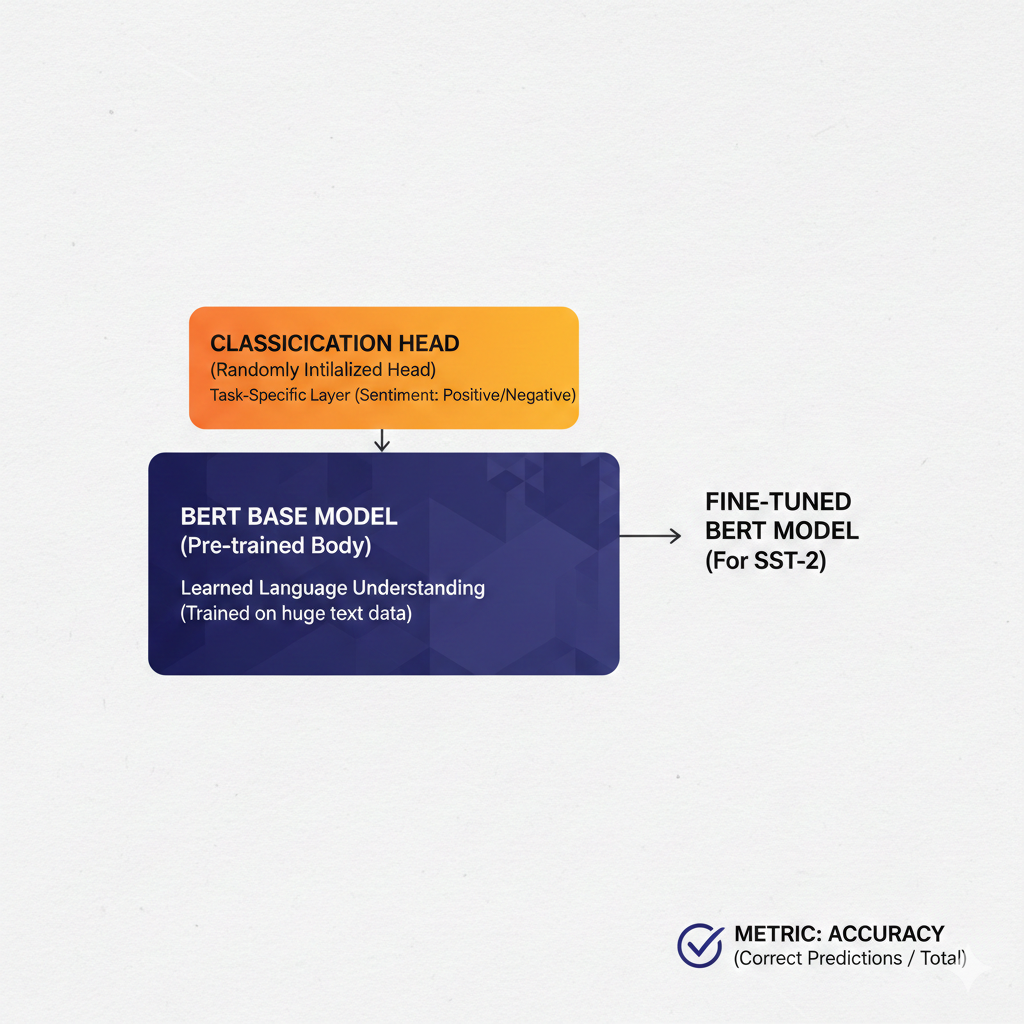

In [52]:
training_args = TrainingArguments(
    output_dir="./bert-sst2-demo",
    per_device_train_batch_size=8,   # Ajustar según la memoria VRAM de tu GPU
    per_device_eval_batch_size=16,
    num_train_epochs=1,              # Mantenemos 1 para demo. Usar 3 o más para resultados óptimos.
    logging_steps=10,                # Registrar métricas cada 10 pasos
    eval_strategy="steps",           # Evaluar durante el entrenamiento
    eval_steps=50,                   # Cada 50 pasos, evaluar en el set de validación
    save_strategy="no",              # No guardar checkpoints intermedios para ahorrar espacio en disco
    learning_rate=2e-5,              # Tasa de aprendizaje estándar para BERT
    weight_decay=0.01,               # Regularización
    load_best_model_at_end=False,
    fp16=torch.cuda.is_available(),  # Usar precisión mixta si hay GPU (ahorra memoria)
    report_to="none",                # Desactiva reportes a WandB/MLflow para este demo
)

---

### 7. Ejecución del Entrenamiento (Trainer)

La clase `Trainer` de Hugging Face abstrae el bucle de entrenamiento complejo (forward pass, backward pass, optimizer step). Solo necesitamos pasarle el modelo, los argumentos, los datos y la métrica.


In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

print("Iniciando entrenamiento...")
trainer.train()

Iniciando entrenamiento...


Step,Training Loss,Validation Loss,Accuracy
50,0.605700,0.550381,0.835000
100,0.340200,0.330790,0.890000


TrainOutput(global_step=125, training_loss=0.5167644348144531, metrics={'train_runtime': 10.2205, 'train_samples_per_second': 97.842, 'train_steps_per_second': 12.23, 'total_flos': 65777763840000.0, 'train_loss': 0.5167644348144531, 'epoch': 1.0})

---

### 8. Evaluación y Guardado

Una vez terminado el entrenamiento, verificamos el rendimiento final en el set de validación y guardamos el modelo para usarlo después.


In [54]:
# Evaluar modelo final
res = trainer.evaluate()
print("Resultados de evaluación:", res)

# Guardar el modelo entrenado
save_path = "./bert-sst2-demo/saved"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"Modelo guardado en: {save_path}")

Resultados de evaluación: {'eval_loss': 0.32154831290245056, 'eval_accuracy': 0.9, 'eval_runtime': 0.3508, 'eval_samples_per_second': 570.158, 'eval_steps_per_second': 37.06, 'epoch': 1.0}
Modelo guardado en: ./bert-sst2-demo/saved


### 9. Inferencia (Prueba Real)

Finalmente, probamos el modelo con frases nuevas que nunca ha visto.

Calculamos las probabilidades usando la función Softmax:

$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

Esto convierte la salida numérica del modelo (logits) en probabilidades interpretables (0% a 100%).

In [55]:
def predict(texts):
    """Realiza inferencia sobre una lista de textos."""
    # 1. Tokenizar inputs
    toks = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to(model.device)

    # 2. Pasar por el modelo (modo evaluación)
    model.eval()
    with torch.no_grad():
        out = model(**toks)

    # 3. Procesar resultados (Logits -> Softmax -> Argmax)
    logits = out.logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    preds = np.argmax(probs, axis=-1)

    return preds, probs

# --- Prueba ---
examples = ["This movie was great!", "I did not like the film at all."]

predictions, probabilities = predict(examples)

label_map = {0: "NEGATIVO", 1: "POSITIVO"}

print("-" * 30)
for text, pred, prob in zip(examples, predictions, probabilities):
    print(f"Texto: {text}")
    print(f"Sentimiento: {label_map[pred]} (Confianza: {prob[pred]:.2%})")
    print("-" * 30)

------------------------------
Texto: This movie was great!
Sentimiento: POSITIVO (Confianza: 95.05%)
------------------------------
Texto: I did not like the film at all.
Sentimiento: NEGATIVO (Confianza: 76.07%)
------------------------------
